In [10]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.preprocessing import LabelEncoder

"""
Name: feature_extract
Input: String name of file to analyze
Returns: 
Array of:
    y_harmonic
    y_percussive 
    chroma_cens 
    mfcc
    mel_spec
    spec_contrast
Note: 
    MFCC and Chroma_cens are arrays of 12
    Mel_spec and spec_contrast are also arrays of 1xN.
"""
def feature_extract(file):
    y, sr = librosa.load(file, sr=None)
    
    hop_length = 512
    
    # Separate harmonics and percussives into two waveforms
    y_harmonic, y_percussive = librosa.effects.hpss(y)    
    
    #Chroma Energy Normalized (CENS)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    
    #Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, 
                                                 fmax = 8000)
    #Mel-Frequency Cepstral Coefficients (MFCC) features from the raw signal
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
    
    #Spectral Contrast
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    
    y_harmonic = np.mean(y_harmonic)
    y_percussive = np.mean(y_percussive)
    mel_spec = np.mean(mel_spec, axis=1)
    mfcc = np.mean(mfcc, axis=1)
    chroma_cens = np.mean(chroma_cens,axis=1)
    spec_contrast = np.mean(spec_contrast, axis=1)
    
    return [y_harmonic, y_percussive, chroma_cens, mfcc, mel_spec, 
            spec_contrast]

"""
Name: get_dataset
Input: 
    data_group: Train, valid, test set name
    source: Acoustic, electronic, synthetic
    class1: First instrument to classify
    class2: second instrument to classify
Returns: 
Array of:
    y_harmonic
    y_percussive 
    mel_spec
    mfcc_0-12
    chroma_0-12
    spec_contrast
    
NOTE: 
In this version of get_dataset, NSynth Qualities are not used.
This is because the RACK dataset does not include the annotations,
and therefore cannot be used for model building or predicting.
"""
def get_dataset(data_group, source, class1, class2):#, instrument, source):
    
    new_dir='Dataset/'+data_group+'/audio/'     #set the audio directory (test, train, etc)
    #read all instruments from examples.json
    dataframe_raw = pd.read_json(path_or_buf='Dataset/'+data_group+'/examples.json', orient='index') 
    #narrow down by family (strings, etc)
    dataframe_specific = dataframe_raw.loc[(dataframe_raw['instrument_family_str'] == class1) 
                                           | (dataframe_raw['instrument_family_str'] == class2)]
    #narrow down by source (acoustic, etc)
    dataframe_specific = dataframe_specific.loc[dataframe_specific['instrument_source_str'] == source]     

    Y_target_class = dataframe_specific.instrument_family_str.replace(to_replace=[class1, class2], value=[0, 1])
    filenames = dataframe_specific.index.tolist()     #get filenames from our dataframe, put into list
    
    dictionary = {}
    #Create the dictionary of files.
    #Note: TQDM is a loading bar
    for file in tqdm_notebook(filenames):           
        features = feature_extract((new_dir+file+'.wav'))
        dictionary[file] = features
    
    feature_dataframe = pd.DataFrame.from_dict(dictionary, orient='index',
                                       columns=['y_harmonic', 'y_percussive', 'chroma_cens', 
                                                'mfcc', 'mel_spec', 'spec_contrast'])
    
    #Take averages of each coefficient etc and create their own feature
    mel_spec_data = pd.DataFrame(feature_dataframe.mel_spec.values.tolist(), 
                                 index=feature_dataframe.index)
    mel_spec_data = mel_spec_data.add_prefix('Mel_Spec_')
    
    mfcc_data = pd.DataFrame(feature_dataframe.mfcc.values.tolist(), 
                             index=feature_dataframe.index)
    mfcc_data = mfcc_data.add_prefix('MFCC_')
    
    chroma_data = pd.DataFrame(feature_dataframe.chroma_cens.values.tolist(), 
                               index=feature_dataframe.index)
    chroma_data = chroma_data.add_prefix('Chroma_')
    
    spec_contrast_data = pd.DataFrame(feature_dataframe.spec_contrast.values.tolist(), 
                                      index=feature_dataframe.index)
    spec_contrast_data = spec_contrast_data.add_prefix('Spec_Contrast_')
    
    #Drop the old feature columns
    feature_dataframe = feature_dataframe.drop(
        labels=['mel_spec', 'mfcc',
                'chroma_cens', 'spec_contrast'],
                                       axis=1)
    #Add the extracted features
    feature_dataframe = pd.concat([feature_dataframe, mel_spec_data, mfcc_data, 
                           chroma_data, spec_contrast_data],
                         axis = 1, join='inner')
    
    feature_dataframe['target'] = Y_target_class
    feature_dataframe.to_csv('./RACK_'+data_group+'.csv')
    
    #returns dataframe of features
    return feature_dataframe 

"""
Name: equalize_data
Input: 
    class1: Data in class1
    class2: Data in class2
Returns: 
    equalized data from training
"""
def equalize_data(class1, class2):
    class1_copy = class1
    class2_copy = class2  
    if (class1_copy['y_harmonic'].count() < class2_copy['y_harmonic'].count()):
        while (class1_copy['y_harmonic'].count()<class2_copy['y_harmonic'].count()): 
            temp = [class1_copy, class1]
            class1_copy = pd.concat(temp)
        class2_copy = class2_copy[:class1_copy['y_harmonic'].count()]
    else:
        while (class2_copy['y_harmonic'].count()<class1_copy['y_harmonic'].count()):
            temp = [class2_copy, class2]
            class2_copy = pd.concat(temp)
        class2_copy = class2_copy[:class1_copy['y_harmonic'].count()]
    return (pd.concat([class1_copy, class2_copy]))

def count_errors(predictions):
    count = 0;
    for pred in predictions:
        if (pred[0] != pred[1]):
            count += 1
    return count;

print('functions declared')

functions declared


In [2]:
# get string members from dataset
df_train = get_dataset('nsynth-valid', 'acoustic', 'keyboard','string')
# get string members from dataset
df_test = get_dataset('rack', 'acoustic', 'keyboard','string')

In [11]:
# balance the datasets
input_df_train = equalize_data(df_train[df_train['target'] == 0], df_train[df_train['target'] == 1])
input_df_test = equalize_data(df_test[df_test['target'] == 0], df_test[df_test['target'] == 1])

# randomize datasets
input_df_train = input_df_train.sample(frac=1).reset_index(drop=True)
input_df_test = input_df_test.sample(frac=1).reset_index(drop=True)
# Separate the target and the columns
y_train = input_df_train['target']
x_train = input_df_train.drop(labels=['target'], axis=1)
# Separate the target and the columns
y_test = input_df_test['target']
x_test = input_df_test.drop(labels=['target'], axis=1)

data_length_train = len(x_train)
data_length_test = len(x_test)


started
class 1 321
class 2 814
done1
class 1 37
class 2 54
done2
done3
done4


In [12]:
def simple_decision_tree(max_depth):
    # hyperparameters
    # max_depth of 4 seems to work well for training with validation set

    # create a scikit-learn tree based on validation set
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf = clf.fit(x_train, y_train)

    # make predictions
    predictions_test = np.vstack((y_test, clf.predict(x_test).tolist())).T
    predictions_train = np.vstack((y_train, clf.predict(x_train).tolist())).T

    num_errors_train = count_errors(predictions_train)
    num_errors_test = count_errors(predictions_test)

    # calculating train and test error to two decimal places
    error_percent_train = round(num_errors_train / data_length_train * 100, 2);
    error_percent_test = round(num_errors_test / data_length_test * 100, 2)

    errorLabels = ('Train Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Error in Train vs Test")
    plt.ylabel("Error (%)")
    plt.bar('Train', error_percent_train)
    plt.bar('Test', error_percent_test)

    print('Validation set error percentage: ', error_percent_train)
    print('Test set error percentage: ', error_percent_test)


Validation set error percentage:  0.0
Test set error percentage:  54.69


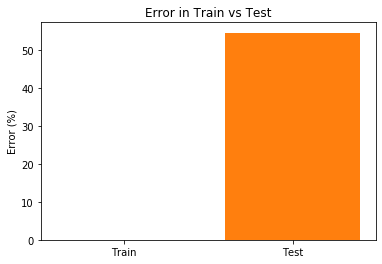

In [23]:
# fit a tree to our data and plot error
simple_decision_tree(4)

In [24]:
def ada_boost(estimators):
    classifier = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1),
        n_estimators=estimators
    )
    classifier.fit(x_test, y_test)
    predictions_test = classifier.predict(x_test)
    results_test = confusion_matrix(y_test, predictions_test)
    predictions_valid = classifier.predict(x_valid)
    results_valid = confusion_matrix(y_valid, predictions_valid)
    num_errors_test = results_test[0][1] + results_test[1][0]
    num_errors_valid = results_valid[0][1] + results_valid[1][0]
    
    # calculating valid and test error to two decimal places
    data_length_test = len(predictions_test)
    data_length_valid = len(predictions_valid)
    error_percent_valid = round(num_errors_valid / data_length_valid * 100, 2);
    error_percent_test = round(num_errors_test / data_length_test * 100, 2)

    errorLabels = ('Validation Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Error in Validation vs Test")
    plt.ylabel("Error (%)")
    plt.bar('Valid', error_percent_valid)
    plt.bar('Test', error_percent_test)

    print('Validation set error percentage: ', error_percent_valid)
    print('Test set error percentage: ', error_percent_test)

In [25]:
ada_boost(50)

NameError: name 'confusion_matrix' is not defined